# IMPORT LIBRARIES

In [3]:
import numpy as np
import pandas as pd # pandas allows to do a lot of basic data manipulation such as loading csv data files
from datetime import datetime
import matplotlib.pyplot as plt # matplotlib is a basic ploting library of Python

# READ DATA

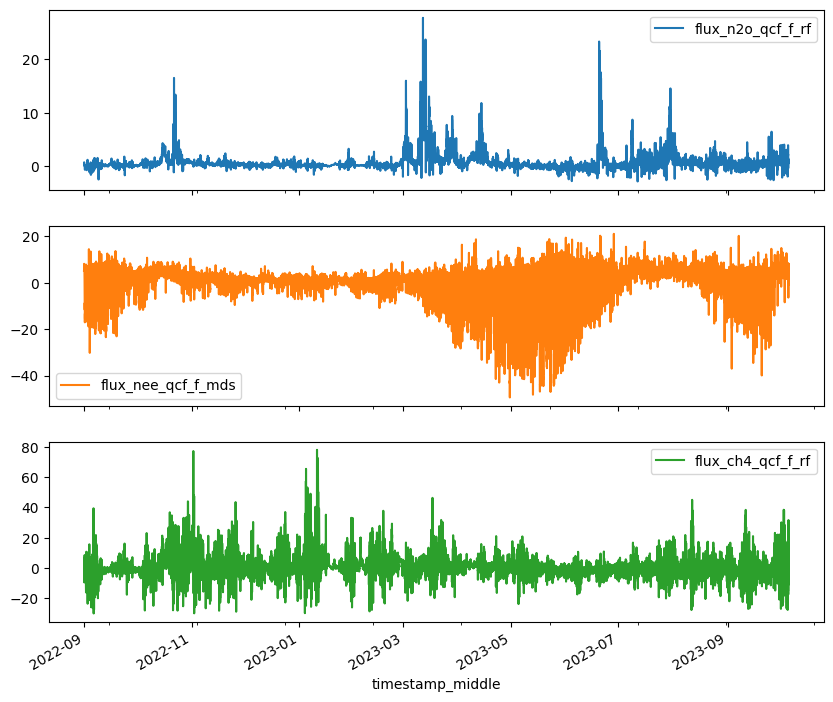

,flux_n2o_qcf_f_rf,flux_nee_qcf_f_mds,flux_ch4_qcf_f_rf,timesince_fert
timestamp_middle,,,,
2022-09-01 00:15:00,0.496789,5.221036,-1.078365,30
2022-09-01 00:45:00,0.574461,5.270603,-1.751478,30
2022-09-01 01:15:00,0.733034,8.111594,-0.762119,30
2022-09-01 01:45:00,0.404464,6.371694,-1.258747,30
2022-09-01 02:15:00,0.348086,5.461992,-1.429250,30
...,...,...,...,...
2023-10-05 10:15:00,1.337405,6.244132,31.687720,30
2023-10-05 10:45:00,0.782718,3.702135,0.432940,30
2023-10-05 11:15:00,0.604505,4.164610,1.899206,30


In [4]:
time_resolution = '0.5' # set time resolution in hours
file_path = '../data/processed/DRIVERS_dataset_' + time_resolution + 'h.csv'
data = pd.read_csv(file_path, low_memory=False)
# Fix column names so all lower case, no spaces or special characters
data.columns = data.columns.str.lower().str.replace(' ', '_').str.replace(r'[^a-zA-Z0-9_]', '')
# Fix date to a datetime object
data['timestamp_middle'] = pd.to_datetime(data['timestamp_middle'], format='%Y-%m-%d %H:%M:%S')
# Set timestamp as index
data.set_index('timestamp_middle', inplace=True)
# Select the columns we are interested
fluxes = ['flux_n2o_qcf_f_rf', 'flux_nee_qcf_f_mds', 'flux_ch4_qcf_f_rf']
sel_cols = fluxes + ['timesince_fert']

# Set time interval
df = data.loc['2022-09-01':'2023-10-05', sel_cols].copy()

# Plot fluxes
df[fluxes].plot(figsize=(10,9), x_compat=True, subplots=True)
plt.show()

df

## CONVERT UNITS

- Convert to 30 min by multiplying by seconds in 1 minute and then by 30 min (* 60 * 30)
- Multiply by the molar weight
- Convert the molar weight to grams

In [5]:
# For N budget
df['FN2O_N'] = df['flux_n2o_qcf_f_rf'] * 60 * 30 * 28.014 * 1e-9 * 1e-3 * 1e4 # nmol N2O m-2 s-1 → kg N2O-N ha-1 30min-1

# For GHG budget
df['FN2O'] = df['flux_n2o_qcf_f_rf'] * 60 * 30 * 44.0128 * 1e-9 # nmol N2O m-2 s-1 → g N2O m-2 30min-1
df['FCO2'] = df['flux_nee_qcf_f_mds'] * 60 * 30 * 44.0095 * 1e-6 # umol CO2 m-2 s-1 → g CO2 m-2 30min-1
df['FCH4'] = df['flux_ch4_qcf_f_rf'] * 60 * 30 * 16.0425 * 1e-9 # nmol CH4 m-2 s-1 → g CH4 m-2 30min-1

# CALCULATE BUDGETS

## N BUDGET

### WHEAT

In [6]:
print('N2O-N WINTER WHEAT\n')

start_date = '2022-10-06'
end_date = '2023-07-15'

# Calculate number of days of the aggregation period
start = datetime.strptime(start_date, '%Y-%m-%d')
end = datetime.strptime(end_date, '%Y-%m-%d')
n_days = (end - start).days
print(f"Aggregation period: {start_date} to {end_date} ({n_days} days)\n")

# N2O N budget
N2O_N_BUDGET = np.sum(df.loc[start_date:end_date,'FN2O_N'])
print(f'N2O-N (kg N2O-N ha-1): {N2O_N_BUDGET:.3f}')
print(f'N2O-N per day (g N2O-N day-1 ha-1): {(N2O_N_BUDGET * 1000 / n_days):.3f}')

# Calculate background N2O-N flux
baseline_fn2o = df.loc[
    (df.index >= start_date) & (df.index <= end_date) & (df['timesince_fert'] > 28),
    'flux_n2o_qcf_f_rf'
].mean()
df.loc[start_date:end_date,'FN2O_N_baseline'] = baseline_fn2o * 60 * 30 * 28.014 * 1e-9 * 1e-3 * 1e4 # nmol N2O m-2 s-1 → kg N2O-N ha-1 30min-1
N2O_N_baseline_cum = np.sum(df.loc[start_date:end_date,'FN2O_N_baseline'])
print(f'N2O flux background (nmol N2O m-2 s-1):{baseline_fn2o:.3f}')
print(f'N2O-N background (kg N2O-N ha-1):{N2O_N_baseline_cum:.3f}')
print(f'N2O-N background per day (g N2O-N day-1 ha-1):{N2O_N_baseline_cum*1000/n_days:.3f}')

# Net N2O-N loss
print(f'N2O-N minus background (kg N2O-N ha-1): {N2O_N_BUDGET - N2O_N_baseline_cum:.3f}')
print(f'N2O-N minus background per day (g N2O-N day-1 ha-1): {(N2O_N_BUDGET - N2O_N_baseline_cum)*1000/n_days:.3f}')

N2O-N WINTER WHEAT

Aggregation period: 2022-10-06 to 2023-07-15 (282 days)

N2O-N (kg N2O-N ha-1): 5.521
N2O-N per day (g N2O-N day-1 ha-1): 19.580
N2O flux background (nmol N2O m-2 s-1):0.443
N2O-N background (kg N2O-N ha-1):3.037
N2O-N background per day (g N2O-N day-1 ha-1):10.769
N2O-N minus background (kg N2O-N ha-1): 2.485
N2O-N minus background per day (g N2O-N day-1 ha-1): 8.811


Check estimated background flux

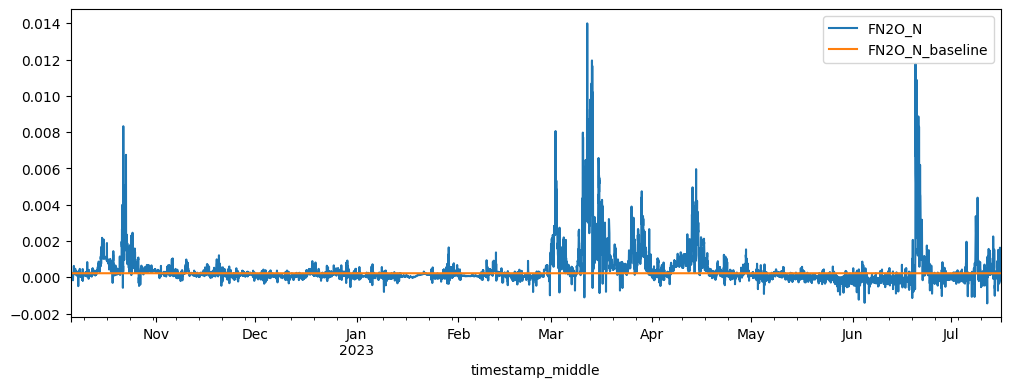

In [7]:
df[['FN2O_N', 'FN2O_N_baseline']][start_date:end_date].plot(figsize=(12,4));

### COVER CROP

In [8]:
start_date = '2023-07-27'
end_date = '2023-09-25'

# Calculate number of days of the aggregation period
start = datetime.strptime(start_date, '%Y-%m-%d')
end = datetime.strptime(end_date, '%Y-%m-%d')
n_days = (end - start).days

print('N2O-N COVER CROP\n')
print(f"Aggregation period: {start_date} to {end_date} ({n_days} days)\n")
N2O_N_BUDGET = np.sum(df.loc[start_date:end_date,'FN2O_N'])
print(f'N2O-N (kg N2O-N ha-1): {N2O_N_BUDGET:.3f}')
print(f'N2O-N per day (g N2O-N day-1 ha-1): {(N2O_N_BUDGET * 1000 / n_days):.3f}')

N2O-N COVER CROP

Aggregation period: 2023-07-27 to 2023-09-25 (60 days)

N2O-N (kg N2O-N ha-1): 1.057
N2O-N per day (g N2O-N day-1 ha-1): 17.618


## GHG budgets

### WHEAT

In [9]:
start_date = '2022-10-06'
end_date = '2023-07-15'

# Calculate number of days of the aggregation period
start = datetime.strptime(start_date, '%Y-%m-%d')
end = datetime.strptime(end_date, '%Y-%m-%d')
n_days = (end - start).days

CO2_BUDGET = np.sum(df.loc[start_date:end_date,'FCO2'])
N2O_TOTAL = np.sum(df.loc[start_date:end_date,'FN2O'])
N2O_BUDGET = N2O_TOTAL * 273
CH4_TOTAL = np.sum(df.loc[start_date:end_date,'FCH4'])
CH4_BUDGET = CH4_TOTAL * 27 # over a 100-year lifetime
NGHG = CO2_BUDGET + N2O_BUDGET + CH4_BUDGET

print('GHG BUDGET WINTER WHEAT\n')
print(f"Aggregation period: {start_date} to {end_date} ({n_days} days)\n")
print('CO2')
print(f'UNIT: g C-CO2 m-2\n cumulative: {CO2_BUDGET * 12.011/44.009:.3f}')
print(f'UNIT: g CO2 m-2\n cumulative: {CO2_BUDGET:.3f}\n per day: {CO2_BUDGET/n_days:.3f}\n')
print('N2O')
print(f'UNIT: g N-N2O m-2\n cumulative: {N2O_TOTAL * 28.014/44.013:.3f}')
print(f'UNIT: g CO2-eq m-2\n cumulative: {N2O_BUDGET:.3f}\n per day: {N2O_BUDGET/n_days:.3f}\n')
print('CH4')
print(f'UNIT: g C-CH4 m-2\n cumulative: {CH4_TOTAL * 12.011/16.04:.3f}')
print(f'UNIT: g CO2-eq m-2\n cumulative: {CH4_BUDGET:.3f}\n per day: {CH4_BUDGET/n_days:.3f}\n')
print(f'NGHG (g CO2-eq m-2)\n cumulative: {NGHG:.3f}\n per day: {NGHG/n_days:.3f}\n')

GHG BUDGET WINTER WHEAT

Aggregation period: 2022-10-06 to 2023-07-15 (282 days)

CO2
UNIT: g C-CO2 m-2
 cumulative: -89.758
UNIT: g CO2 m-2
 cumulative: -328.878
 per day: -1.166

N2O
UNIT: g N-N2O m-2
 cumulative: 0.552
UNIT: g CO2-eq m-2
 cumulative: 236.819
 per day: 0.840

CH4
UNIT: g C-CH4 m-2
 cumulative: 0.446
UNIT: g CO2-eq m-2
 cumulative: 16.083
 per day: 0.057

NGHG (g CO2-eq m-2)
 cumulative: -75.976
 per day: -0.269



### COVER CROP

In [10]:
start_date = '2023-07-27'
end_date = '2023-09-25'

# Calculate number of days of the aggregation period
start = datetime.strptime(start_date, '%Y-%m-%d')
end = datetime.strptime(end_date, '%Y-%m-%d')
n_days = (end - start).days

CO2_BUDGET = np.sum(df.loc[start_date:end_date,'FCO2'])
N2O_TOTAL = np.sum(df.loc[start_date:end_date,'FN2O'])
N2O_BUDGET = N2O_TOTAL * 273
CH4_TOTAL = np.sum(df.loc[start_date:end_date,'FCH4'])
CH4_BUDGET = CH4_TOTAL * 27 # over a 100-year lifetime
NGHG = CO2_BUDGET + N2O_BUDGET + CH4_BUDGET

print('GHG BUDGET COVER CROP\n')
print(f"Aggregation period: {start_date} to {end_date} ({n_days} days)\n")
print('CO2')
print(f'UNIT: g C-CO2 m-2\n cumulative: {CO2_BUDGET * 12.011/44.009:.3f}')
print(f'UNIT: g CO2 m-2\n cumulative: {CO2_BUDGET:.3f}\n per day: {CO2_BUDGET/n_days:.3f}\n')
print('N2O')
print(f'UNIT: g N-N2O m-2\n cumulative: {N2O_TOTAL * 28.014/44.013:.3f}')
print(f'UNIT: g CO2-eq m-2\n cumulative: {N2O_BUDGET:.3f}\n per day: {N2O_BUDGET/n_days:.3f}\n')
print('CH4')
print(f'UNIT: g C-CH4 m-2\n cumulative: {CH4_TOTAL * 12.011/16.04:.3f}')
print(f'UNIT: g CO2-eq m-2\n cumulative: {CH4_BUDGET:.3f}\n per day: {CH4_BUDGET/n_days:.3f}\n')
print(f'NGHG (g CO2-eq m-2)\n cumulative: {NGHG:.3f}\n per day: {NGHG/n_days:.3f}\n')

GHG BUDGET COVER CROP

Aggregation period: 2023-07-27 to 2023-09-25 (60 days)

CO2
UNIT: g C-CO2 m-2
 cumulative: 108.350
UNIT: g CO2 m-2
 cumulative: 397.001
 per day: 6.617

N2O
UNIT: g N-N2O m-2
 cumulative: 0.106
UNIT: g CO2-eq m-2
 cumulative: 45.338
 per day: 0.756

CH4
UNIT: g C-CH4 m-2
 cumulative: -0.034
UNIT: g CO2-eq m-2
 cumulative: -1.218
 per day: -0.020

NGHG (g CO2-eq m-2)
 cumulative: 441.121
 per day: 7.352

